## **Model 7 : Medium CNN (base Model 5) with 5×5 filters instead of 3×3**

Out of the past three models, I will be using model 5 as it has good accuracy, excellent validation, and reasonable training time.

**Preprocessing from model 2**

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

IMG_SIZE = (128, 128)
BATCH_SIZE = 32
SEED = 42

train_dir = "datasets/Training"
test_dir  = "datasets/Testing"

# Load datasets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Validation split
val_size = int(0.2 * len(train_ds))
val_ds = train_ds.take(val_size)
train_ds = train_ds.skip(val_size)

# Normalize
normalization_layer = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x,y: (normalization_layer(x), y))
val_ds   = val_ds.map(lambda x,y: (normalization_layer(x), y))
test_ds  = test_ds.map(lambda x,y: (normalization_layer(x), y))

# Prefetch
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)
test_ds  = test_ds.cache().prefetch(AUTOTUNE)


Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


**Medium CNN with 5×5 Filters**
 > Architecture
- Conv2D(32, 5×5) → ReLU → MaxPool
- Conv2D(64, 5×5) → ReLU → MaxPool
- Conv2D(128, 5×5) → ReLU → MaxPool
- Flatten → Dense(128, ReLU) → Dense(4, softmax)

In [12]:
def build_medium_cnn_5x5(input_shape=(128,128,3), num_classes=4):
    model = models.Sequential([
        layers.Conv2D(32, (5,5), activation='relu', padding='same', input_shape=input_shape),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(64, (5,5), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(128, (5,5), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

model7 = build_medium_cnn_5x5()
model7.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,453,572 (16.99 MB)

 Trainable params: 4,453,572 (16.99 MB)

 Non-trainable params: 0 (0.00 B)

**Callbacks**

In [13]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        min_delta=1e-3,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='models/model07_best.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
]

**Compile**

In [14]:
model7.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

**Train**

In [15]:
history7 = model7.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.5641 - loss: 0.9725
Epoch 1: val_loss improved from None to 0.38562, saving model to models/model07_best.h5


144/144 ━━━━━━━━━━━━━━━━━━━━ 49s 331ms/step - accuracy: 0.6879 - loss: 0.7345 - val_accuracy: 0.8455 - val_loss: 0.3856 - learning_rate: 0.0010
Epoch 2/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.8339 - loss: 0.4241
Epoch 2: val_loss did not improve from 0.38562
144/144 ━━━━━━━━━━━━━━━━━━━━ 46s 321ms/step - accuracy: 0.8534 - loss: 0.3822 - val_accuracy: 0.8509 - val_loss: 0.4132 - learning_rate: 0.0010
Epoch 3/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.9121 - loss: 0.2605
Epoch 3: val_loss improved from 0.38562 to 0.22187, saving model to models/model07_best.h5


144/144 ━━━━━━━━━━━━━━━━━━━━ 46s 322ms/step - accuracy: 0.9242 - loss: 0.2278 - val_accuracy: 0.9187 - val_loss: 0.2219 - learning_rate: 0.0010
Epoch 4/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.9455 - loss: 0.1608
Epoch 4: val_loss improved from 0.22187 to 0.17392, saving model to models/model07_best.h5


144/144 ━━━━━━━━━━━━━━━━━━━━ 46s 321ms/step - accuracy: 0.9490 - loss: 0.1549 - val_accuracy: 0.9304 - val_loss: 0.1739 - learning_rate: 0.0010
Epoch 5/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.9587 - loss: 0.1174
Epoch 5: val_loss did not improve from 0.17392
144/144 ━━━━━━━━━━━━━━━━━━━━ 46s 323ms/step - accuracy: 0.9630 - loss: 0.1117 - val_accuracy: 0.9330 - val_loss: 0.1954 - learning_rate: 0.0010
Epoch 6/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.9728 - loss: 0.0737
Epoch 6: val_loss did not improve from 0.17392
144/144 ━━━━━━━━━━━━━━━━━━━━ 46s 323ms/step - accuracy: 0.9784 - loss: 0.0688 - val_accuracy: 0.9348 - val_loss: 0.2385 - learning_rate: 0.0010
Epoch 7/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.9773 - loss: 0.0639
Epoch 7: val_loss did not improve from 0.17392

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
144/144 ━━━━━━━━━━━━━━━━━━━━ 46s 321ms/step - accuracy: 0.9765 - loss: 0.0663 - val_ac

144/144 ━━━━━━━━━━━━━━━━━━━━ 46s 322ms/step - accuracy: 0.9911 - loss: 0.0260 - val_accuracy: 0.9589 - val_loss: 0.1568 - learning_rate: 5.0000e-04
Epoch 9/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.9971 - loss: 0.0127
Epoch 9: val_loss did not improve from 0.15679
144/144 ━━━━━━━━━━━━━━━━━━━━ 46s 321ms/step - accuracy: 0.9980 - loss: 0.0096 - val_accuracy: 0.9616 - val_loss: 0.1638 - learning_rate: 5.0000e-04
Epoch 10/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.9984 - loss: 0.0060
Epoch 10: val_loss did not improve from 0.15679
144/144 ━━━━━━━━━━━━━━━━━━━━ 46s 322ms/step - accuracy: 0.9987 - loss: 0.0042 - val_accuracy: 0.9661 - val_loss: 0.1786 - learning_rate: 5.0000e-04
Epoch 11/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 1.0000 - loss: 0.0016
Epoch 11: val_loss did not improve from 0.15679

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
144/144 ━━━━━━━━━━━━━━━━━━━━ 46s 321ms/step - accuracy: 1.0000 - loss

**Load best model**

In [16]:
best_model7 = tf.keras.models.load_model('models/model07_best.h5')

**Evaluate**

In [17]:
# Evaluate on test set
test_loss, test_acc = model7.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")

# Get final training & validation metrics
final_train_acc = history7.history['accuracy'][-1]
final_train_loss = history7.history['loss'][-1]
final_val_acc   = history7.history['val_accuracy'][-1]
final_val_loss  = history7.history['val_loss'][-1]

print(f"Final training accuracy: {final_train_acc:.4f}")
print(f"Final training loss: {final_train_loss:.4f}")
print(f"Final validation accuracy: {final_val_acc:.4f}")
print(f"Final validation loss: {final_val_loss:.4f}")


41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 0.9527 - loss: 0.1865
Test accuracy: 0.9527
Test loss: 0.1865
Final training accuracy: 1.0000
Final training loss: 0.0004
Final validation accuracy: 0.9643
Final validation loss: 0.2062


**Loss curve plotting**

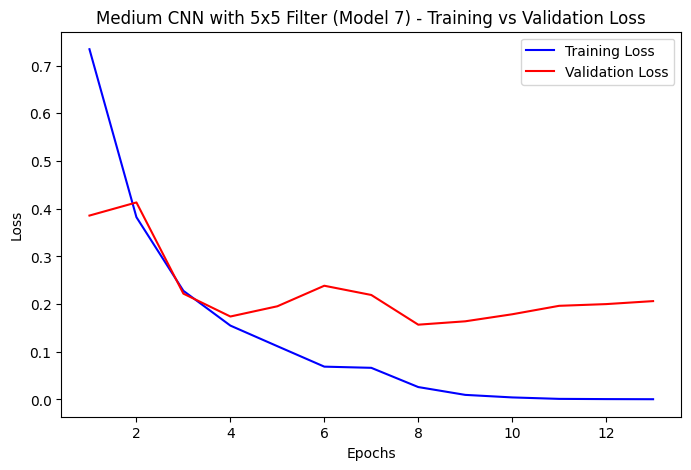

In [ ]:
import matplotlib.pyplot as plt

def plot_loss_curves(history, model_name="Model"):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title(f'{model_name} - Training vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Call for Model
plot_loss_curves(history7, model_name="Medium CNN with 5x5 Filter (Model 7)")

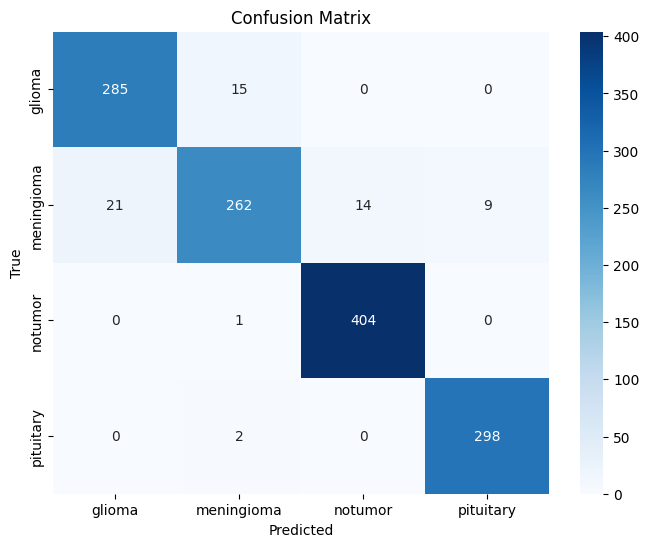


Classification Report:

              precision    recall  f1-score   support

      glioma       0.93      0.95      0.94       300
  meningioma       0.94      0.86      0.89       306
     notumor       0.97      1.00      0.98       405
   pituitary       0.97      0.99      0.98       300

    accuracy                           0.95      1311
   macro avg       0.95      0.95      0.95      1311
weighted avg       0.95      0.95      0.95      1311



In [2]:
from plot_utils import plot_confusion_matrix_from_dataset

class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Confusion matrix from saved model
plot_confusion_matrix_from_dataset("models/model07_best.h5", test_ds, class_names)
